# Image segmentation

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

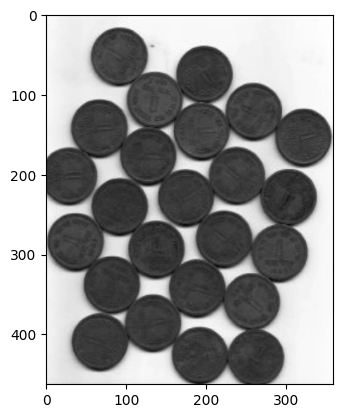

In [10]:
img_path = os.path.join('..', '..', 'pics', 'coins.png')
img = cv.imread(img_path)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [11]:
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

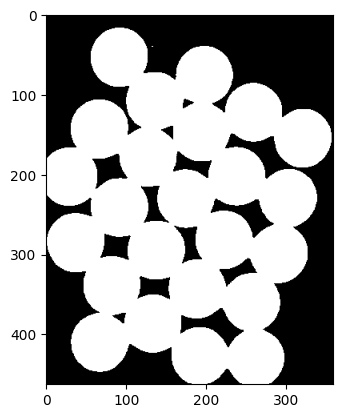

In [15]:
plt.imshow(thresh, cmap='gray')

Now we need to remove any small white noises in the image. For that we can use morphological opening. To remove any small holes in the object, we can use morphological closing. So, now we know for sure that region near to center of objects are foreground and region much away from the object are background. Only region we are not sure is the boundary region of coins.

So we need to extract the area which we are sure they are coins. Erosion removes the boundary pixels. So whatever remaining, we can be sure it is coin. That would work if objects were not touching each other. But since they are touching each other, another good option would be to find the distance transform and apply a proper threshold. Next we need to find the area which we are sure they are not coins. For that, we dilate the result. Dilation increases object boundary to background. This way, we can make sure whatever region in background in result is really a background, since boundary region is removed. See the image below.

In [16]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
 
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
 
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
 
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

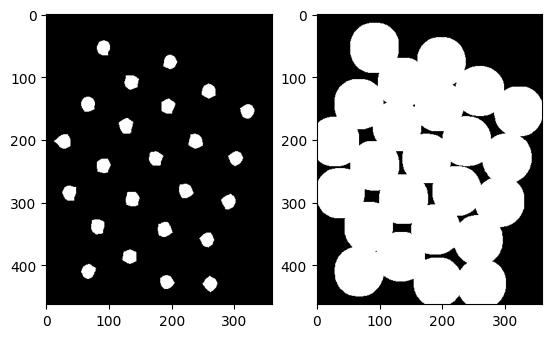

In [18]:
plt.subplot(121)
plt.imshow(sure_fg, cmap='gray')
plt.subplot(122)
plt.imshow(sure_bg, cmap='gray')

The remaining regions are those which we don't have any idea, whether it is coins or background. Watershed algorithm should find it. These areas are normally around the boundaries of coins where foreground and background meet (Or even two different coins meet). We call it border. It can be obtained from subtracting sure_fg area from sure_bg area.

In [19]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
 
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
 
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

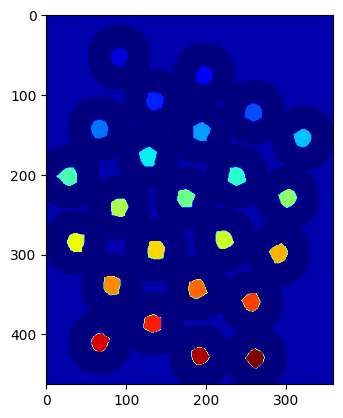

In [22]:
plt.imshow(markers, cmap='jet')

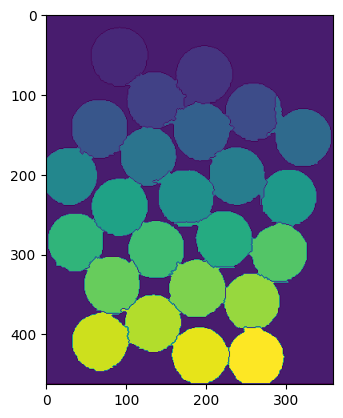

In [ ]:
markers = cv.watershed(img, markers)
img[markers == -1] = [255,0,0]
plt.imshow(markers)